<a href="https://colab.research.google.com/github/CardosoJr/bootcamp/blob/main/Labs/Math/Linear_Regression_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algebra Linear e Regressão Linear

**Vamos rodar um exemplo simples**

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

# Importando libs de plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## Ler Dados

Vamos utilizar os dados salvos em https://github.com/CardosoJr/bootcamp/tree/main/Datasets/House%20prices

In [ ]:
df = pd.read_csv('train.csv')

### Limpando o dataset

In [ ]:
categorical_features = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

ordinal_features_1 = ["ExterQual",
                    "ExterCond",
                    "BsmtQual",
                    "BsmtCond",
                    "HeatingQC",
                    "KitchenQual",
                    "FireplaceQu",
                    "GarageQual",
                    "GarageCond",
                    "PoolQC",]

type_1_map = {"Po" : 0,
               "Fa" : 1,
               "TA" : 2,
               "Gd" : 3,
               "Ex" : 4}


other_feature_maps = {"LotShape": {"Reg" : 0, "IR1"  : 1, "IR2" : 2, "IR3" : 3},
                      "LandSlope": {"Sev" : 0, "Mod" : 1, "Gtl" : 2},
                      "BsmtExposure": {"No" : 0, "Mn" : 1, "Av" : 2, "Gd" : 3},
                      "BsmtFinType1": {"Unf" : 0, "LwQ" : 1, "Rec" : 2, "BLQ" : 3, "ALQ" : 4, "GLQ" : 5},
                      "BsmtFinType2": {"Unf" : 0, "LwQ" : 1, "Rec" : 2, "BLQ" : 3, "ALQ" : 4, "GLQ" : 5},
                      "Functional": {"Sal" : 0, "Sev" : 1, "Maj1" : 2, "Maj2" : 3, "Mod" : 4, "Min2" : 5, "Min1" : 6, "Typ" : 6},
                      "GarageFinish": {"Unf" : 0, "RFn" : 1, "Fin" : 2},
                      "PavedDrive": {"N" : 0, "P" : 1, "Y" : 2},
                      "Utilities": {"NoSeWa" : 0, "NoSewr" : 1, "AllPub" : 3},
                      "CentralAir": {"N" : 0, "Y" : 1},
                      "Electrical": {"Mix" : 0, "FuseP" : 1, "FuseF" : 2, "FuseA" : 3, "SBrkr" : 4},
                      "Fence": {"MnWw" : 0, "GdWo" : 1, "MnPrv" : 2, "GdPrv" : 3},}



In [ ]:
df['AGE'] = df['YrSold'] - df['YearRemodAdd']
df['TOTAL_NUM_BATHROOMS'] = df['FullBath'] + df['HalfBath']*0.5 + df['BsmtFullBath'] + df['BsmtHalfBath']*0.5
# df['REMODELLED'] = (df['YearRemodAdd'] > df['YearBuilt']).astype('category')
df['TOTAL_AREA'] = df['GrLivArea'] + df['TotalBsmtSF']

# NEW_FEATURES = ['AGE', 'TOTAL_NUM_BATHROOMS', 'REMODELLED']
NEW_FEATURES = ['AGE', 'TOTAL_NUM_BATHROOMS', 'TOTAL_AREA']

In [ ]:
def cleaning_data(df):
  df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
  df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
  df.rename(columns={
      "1stFlrSF": "FirstFlrSF",
      "2ndFlrSF": "SecondFlrSF",
      "3SsnPorch": "Threeseasonporch",
  }, inplace=True)

  for col in ordinal_features_1:
    df[col] = df[col].map(type_1_map).astype('category')
    df[col] = df[col].map(type_1_map).astype('category')

  for col, feature_map in other_feature_maps.items():
    df[col] = df[col].map(feature_map).astype('category')

  for col in categorical_features:
    df[col] = df[col].astype('category')

  return df

def drop_cols(df):
  df.drop(columns = ['PoolQC', 'MiscFeature', 'Alley', 'Id'], inplace = True)
  return df

def impute(df):
  for name in df.select_dtypes("number"):
      df[name] = df[name].fillna(0)
  for name in df.select_dtypes("category"):
    if "None" not in df[name].cat.categories:
      df[name].cat.add_categories("None", inplace=True)
    df[name] = df[name].fillna("None")
  return df

df = cleaning_data(df)
df = drop_cols(df)
df = impute(df)

In [ ]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,FirstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,AGE,TOTAL_NUM_BATHROOMS,TOTAL_AREA
0,60,RL,65.0,8450,Pave,0,Lvl,3,Inside,2,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,None,None,PConc,None,None,0.0,5.0,706,0.0,0,150,856,GasA,None,1,4.0,856,854,0,1710,1,0,2,1,3,1,None,8,6,0,None,Attchd,2003.0,1.0,2,548,None,None,2,0,61,0,0,0,0,None,0,2,2008,WD,Normal,208500,5,3.5,2566
1,20,RL,80.0,9600,Pave,0,Lvl,3,FR2,2,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,None,None,CBlock,None,None,3.0,4.0,978,0.0,0,284,1262,GasA,None,1,4.0,1262,0,0,1262,0,1,2,0,3,1,None,6,6,1,None,Attchd,1976.0,1.0,2,460,None,None,2,298,0,0,0,0,0,None,0,5,2007,WD,Normal,181500,31,2.5,2524
2,60,RL,68.0,11250,Pave,1,Lvl,3,Inside,2,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,None,None,PConc,None,None,1.0,5.0,486,0.0,0,434,920,GasA,None,1,4.0,920,866,0,1786,1,0,2,1,3,1,None,6,6,1,None,Attchd,2001.0,1.0,2,608,None,None,2,0,42,0,0,0,0,None,0,9,2008,WD,Normal,223500,6,3.5,2706
3,70,RL,60.0,9550,Pave,1,Lvl,3,Corner,2,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,None,None,BrkTil,None,None,0.0,4.0,216,0.0,0,540,756,GasA,None,1,4.0,961,756,0,1717,1,0,1,0,3,1,None,7,6,1,None,Detchd,1998.0,0.0,3,642,None,None,2,0,35,272,0,0,0,None,0,2,2006,WD,Abnorml,140000,36,2.0,2473
4,60,RL,84.0,14260,Pave,1,Lvl,3,FR2,2,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,None,None,PConc,None,None,2.0,5.0,655,0.0,0,490,1145,GasA,None,1,4.0,1145,1053,0,2198,1,0,2,1,4,1,None,9,6,1,None,Attchd,2000.0,1.0,3,836,None,None,2,192,84,0,0,0,0,None,0,12,2008,WD,Normal,250000,8,3.5,3343


In [ ]:
numerical_features = [x for x in df.columns if x not in categorical_features]
target = 'SalePrice'

In [ ]:
df[numerical_features]

,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,FirstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SalePrice,AGE,TOTAL_NUM_BATHROOMS,TOTAL_AREA
0,65.0,8450,0,3,2,7,5,2003,2003,196.0,None,None,None,None,0.0,5.0,706,0.0,0,150,856,None,4.0,856,854,0,1710,1,0,2,1,3,1,None,8,6,0,None,2003.0,1.0,2,548,None,None,2,0,61,0,0,0,0,None,0,2,2008,208500,5,3.5,2566
1,80.0,9600,0,3,2,6,8,1976,1976,0.0,None,None,None,None,3.0,4.0,978,0.0,0,284,1262,None,4.0,1262,0,0,1262,0,1,2,0,3,1,None,6,6,1,None,1976.0,1.0,2,460,None,None,2,298,0,0,0,0,0,None,0,5,2007,181500,31,2.5,2524
2,68.0,11250,1,3,2,7,5,2001,2002,162.0,None,None,None,None,1.0,5.0,486,0.0,0,434,920,None,4.0,920,866,0,1786,1,0,2,1,3,1,None,6,6,1,None,2001.0,1.0,2,608,None,None,2,0,42,0,0,0,0,None,0,9,2008,223500,6,3.5,2706
3,60.0,9550,1,3,2,7,5,1915,1970,0.0,None,None,None,None,0.0,4.0,216,0.0,0,540,756,None,4.0,961,756,0,1717,1,0,1,0,3,1,None,7,6,1,None,1998.0,0.0,3,642,None,None,2,0,35,272,0,0,0,None,0,2,2006,140000,36,2.0,2473
4,84.0,14260,1,3,2,8,5,2000,2000,350.0,None,None,None,None,2.0,5.0,655,0.0,0,490,1145,None,4.0,1145,1053,0,2198,1,0,2,1,4,1,None,9,6,1,None,2000.0,1.0,3,836,None,None,2,192,84,0,0,0,0,None,0,12,2008,250000,8,3.5,3343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,0,3,2,6,5,1999,2000,0.0,None,None,None,None,0.0,0.0,0,0.0,0,953,953,None,4.0,953,694,0,1647,0,0,2,1,3,1,None,7,6,1,None,1999.0,1.0,2,460,None,None,2,0,40,0,0,0,0,None,0,8,2007,175000,7,2.5,2600
1456,85.0,13175,0,3,2,6,6,1978,1988,119.0,None,None,None,None,0.0,4.0,790,2.0,163,589,1542,None,4.0,2073,0,0,2073,1,0,2,0,3,1,None,7,6,2,None,1978.0,0.0,2,500,None,None,2,349,0,0,0,0,0,2.0,0,2,2010,210000,22,3.0,3615
1457,66.0,9042,0,3,2,7,9,1941,2006,0.0,None,None,None,None,0.0,5.0,275,0.0,0,877,1152,None,4.0,1188,1152,0,2340,0,0,2,0,4,1,None,9,6,2,None,1941.0,1.0,1,252,None,None,2,0,60,0,0,0,0,3.0,2500,5,2010,266500,4,2.0,3492
1458,68.0,9717,0,3,2,5,6,1950,1996,0.0,None,None,None,None,1.0,5.0,49,2.0,1029,0,1078,None,3.0,1078,0,0,1078,1,0,1,0,2,1,None,5,6,0,None,1950.0,0.0,1,240,None,None,2,366,0,112,0,0,0,None,0,4,2010,142125,14,2.0,2156


## Casas Similares

In [ ]:
from sklearn.neighbors import NearestNeighbors

def get_knn(df, n, k, feature_names, metric="euclidean"):

    nbrs = NearestNeighbors(n_neighbors=k, algorithm="auto", metric=metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)

    df_res = df.iloc[nbrs_indices[0]]
    df_res["distance"] = list(nbrs_distances[0])

    return df_res

In [ ]:
feature_names = ['SalePrice',
'AGE',
'TOTAL_NUM_BATHROOMS',
'TOTAL_AREA',
'GarageCars',
'LotArea']

In [ ]:
knn_df = get_knn(
    df,
    10,
    5,
    feature_names = feature_names
)

In [ ]:
knn_df[feature_names]

,SalePrice,AGE,TOTAL_NUM_BATHROOMS,TOTAL_AREA,GarageCars,LotArea
10,129500,43,2.0,2080,1,11200
586,130000,8,2.0,1654,1,10267
839,130500,13,1.0,1968,1,11767
713,129000,36,2.0,1920,2,9873
233,128200,34,2.0,1788,1,10650


### Normalizando

In [ ]:
df_train = df[feature_names]

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaler.fit(df_train)
scaled_data = scaler.transform(df_train)
scaled_df = df_train.copy()
scaled_df.loc[:, feature_names] = scaled_data

In [ ]:
scaled_knn_df = get_knn(
    scaled_df,
    10,
    5,
    feature_names = feature_names,
    metric="manhattan"
)

In [ ]:
scaled_knn_df

,SalePrice,AGE,TOTAL_NUM_BATHROOMS,TOTAL_AREA,GarageCars,LotArea,distance
10,0.171523,0.716667,0.333333,0.176991,0.25,0.052034,0.000000
674,0.185430,0.716667,0.333333,0.193329,0.25,0.042742,0.039537
1214,0.178146,0.733333,0.333333,0.163717,0.25,0.047411,0.041186
996,0.180795,0.750000,0.333333,0.178693,0.25,0.049520,0.046820
419,0.188079,0.700000,0.333333,0.179714,0.25,0.039258,0.048722


In [ ]:
df_train.loc[scaled_knn_df.index]

,SalePrice,AGE,TOTAL_NUM_BATHROOMS,TOTAL_AREA,GarageCars,LotArea
10,129500,43,2.0,2080,1,11200
674,140000,43,2.0,2272,1,9200
1214,134500,44,2.0,1924,1,10205
996,136500,45,2.0,2100,1,10659
419,142000,42,2.0,2112,1,8450


## Regressão Linear

In [ ]:
import numpy as np

class MyLinearRegression:

    def __init__(self):

        self.weights = None

    def fit(self, X, y):

        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

        # np.linalg.inv((p,n) @ (n,p)) @ X2.T @ y
        # np.linalg.inv(p, p) @ X2.T @ y
        # (p, p) @ X2.T @ y
        # (p, p) @ (p,n) @ y
        # (p,n) @ y
        # (p,n) @ (n,1)
        # (p,1)

    def predict(self, X):

        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights

        # y_pred tenga (n,1)
        # (n,p) @ (p,1)
        # (n,1)

        return y_pred

In [ ]:
import math
from sklearn.metrics import mean_squared_error, r2_score

def eval_regressor(y_true, y_pred):

    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')

    r2_ = r2_score(y_true, y_pred)
    print(f'R2: {r2_:.2f}')

In [ ]:
from sklearn.model_selection import train_test_split
y = df_train.pop(target)
X = df_train
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [ ]:
mylr = MyLinearRegression()
mylr.fit(X_train, y_train)
preds = mylr.predict(X_test)
eval_regressor(y_test, preds)

RMSE: 42696.02
R2: 0.76


In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
eval_regressor(y_test, preds)

RMSE: 42696.02
R2: 0.76


In [ ]:
mylr.weights

array([ 3.82808956e+03, -7.12573841e+02,  1.34547665e+04,  4.50642539e+01,
        2.44339761e+04,  3.58763694e-01])

In [ ]:
model.coef_

array([-7.12573841e+02,  1.34547665e+04,  4.50642539e+01,  2.44339761e+04,
        3.58763694e-01])

### Ofuscação de Dados

No projeto, vocês terão uma questão desafiadora para responder.

Vamos fazer a múltiplicação $X \times P$ para ofuscar os dados, ou seja, esconder dados sensiveis. Nesse aspecto, é necessário que a matriz $P$ seja invertível, pois os pesos agora derivados analiticamente terão a seguinte forma:

$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

O que a pergunta pede é como $w$ está relacionado a $w_P$. A ideia é encontrar uma equação:

$w = [...] w_P$, sendo $[...]$ alguma fator que múltiplica o vetor de pesos $w_P$ o transformando em $w$.

Vamos usar essas propriedades para resolver esse problema:

<table>
<tr>
<td>Distributividade</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Não-comutatividade</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propriedade associativa da multiplicação</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propriedade de identidade multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversividade da transposição de um produto de matrizes,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>

#### Resposta abaixo





Vamos começar com:
$$w_P = [(XP)^T XP]^{-1} (XP)^T y$$

Sabendo que $(AB)^T = B^TA^T$, então aplicamos essa lógica na equação acima:

$$w_P = [P^T X^T X P]^{-1} (XP)^T y$$

Vamos simplesmente colocar um parêntesis para agrupar os três primeiros termos

$$w_P = [(P^T X^T X) P]^{-1} (XP)^T y$$

Dessa forma, podemos aplicar a propriedade $(AB)^{-1} = B^{-1}A^{-1}$, resultando em:

$$w_P = P^{-1} [P^T X^T X]^{-1} (XP)^T y$$

Aplicamos a mesma lógica para o termo $[P^T X^T X]^{-1}$:

$$w_P = P^{-1} [X^T X]^{-1} [P^T]^{-1} (XP)^T y$$

Vamos expandir agora o termo $(XP)^T$ seguindo a mesma lógica da transposta de uma múltiplicação de matrizes:

$$w_P = P^{-1} [X^T X]^{-1} [P^T]^{-1} P^T X^T y $$

Neste momento, vemos que podemos simplificar o termo $[P^T]^{-1} P^T$. Se lembrarmos que $A^{-1} A = I$, vemos que a matriz $P^T$ é multiplicada pelo seu inverso, resultado na matriz identidade:  

$$w_P = P^{-1} [X^T X]^{-1} I X^T y $$

Vale lembrar que $IA = A$, ou seja, um matriz qualquer multiplicada à matriz identididade é igual ela mesma. Então vamos simplificar o termo $I X^T$, resultando em:

$$w_P = P^{-1} [X^T X]^{-1} X^T y $$

Vale lembrar que $w = (X^T X)^{-1} X^T y $


$$w_P = P^{-1} \boxed{[X^T X]^{-1} X^T y}$$

Então:

$$w_P = P^{-1}w$$.

Para obtermos o caminho inverso, é só multiplicar $P$ nos dois lados da equação

$$P w_P = P P^{-1} w $$

Logo:

$$w = P w_P$$

Finalmente, vamos lembrar que a regressão se resume a

$$\hat{y} = X w$$

No caso, para o problema com ofuscação, temos:

$$\hat{y} = XP w_P$$

Utilizando o resultado obtiado acima, temos $w = P w_P$, logo

$$\hat{y} = XP w_P = Xw$$

Ou seja, concluímos que as previsões não se alteram ao multiplicar a matriz $X$ por $P$.

## O que fazer quando sua regressão parece errada?

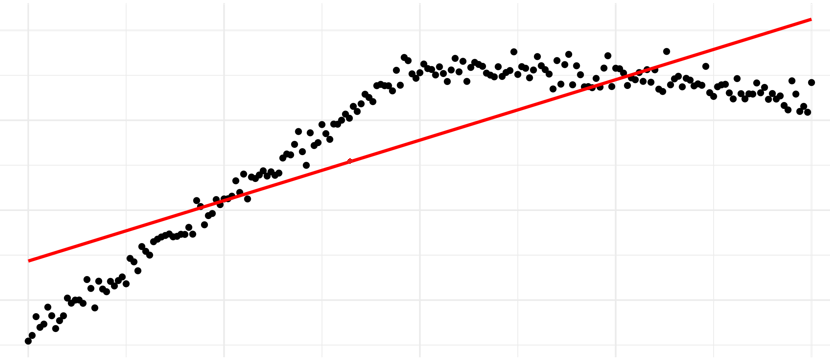



1.   Dados / Encoding incorreto: por exemplo, em um caso onde se tem missing e o valor preenchido como 9999.
2.   Má-interpretação dos resultados: as vezes os resultados estão certos, porém estão sendo mal interpretados. Por exemplo, é preciso tomar cuidado com interpretação de coeficientes quando há interação.
3.   O modelo não é apropriado: há efeitos não-lineares, endogeneidade.
4.   Falta de dados: cuidado com drop de missing values
5.   Multicolinearidade

